In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import glob
import random
from tqdm import tqdm_notebook

import numpy as np
import cv2
import keras
from keras.models import *
from keras.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load Data

In [3]:
def data_generator(batch_size, sequence_length, images):
    """
    Custom data generator for model training
    """
    
    num_images = len(images)
    sequence_length_ = sequence_length
    sequence_length_2 = sequence_length_ * 2
    
    image_range = num_images+1-sequence_length_2
    batch_in, batch_out = [], []
    
    while True:
        for i in range(image_range):
            sequence_in = [images[i+j] for j in range(0, sequence_length_)]
            sequence_out = [images[i+k] for k in range(sequence_length_, sequence_length_2)]
            batch_in.append(sequence_in)
            batch_out.append(sequence_out)
            if len(batch_in) >= batch_size:
                batch_in_ = np.asarray(batch_in)
                batch_out_ = np.asarray(batch_out)
                yield [[batch_in_], [batch_out_]]
                batch_in, batch_out = [], []

In [4]:
DATASET_DIR = "./data"

IMG_PATHS = glob.glob(DATASET_DIR+"/*.jpg")
IMG_PATHS.sort()

print("Number of images:\t", len(IMG_PATHS))
print("Path to first image:\t", IMG_PATHS[0])
print("Path to last image:\t", IMG_PATHS[-1])

Number of images:	 2818
Path to first image:	 ./data/2019012900000000.jpg
Path to last image:	 ./data/2019020719050000.jpg


Showing 9 random images


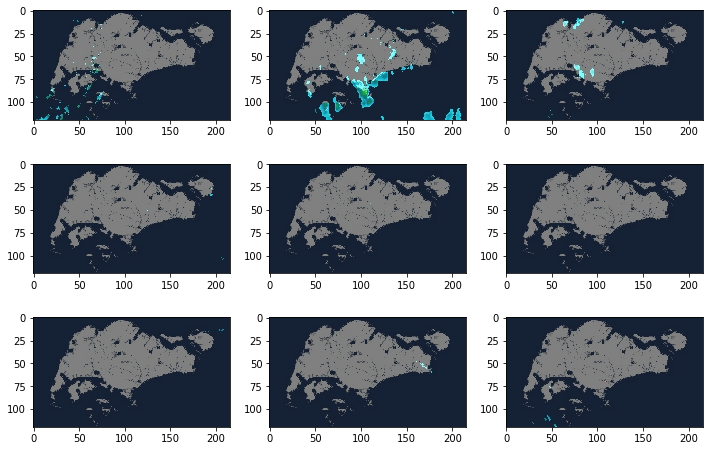

In [5]:
num_images = len(IMG_PATHS)

print("Showing 9 random images")

plt.figure(1, figsize=(12,8))

for i in range(9):
    n = random.randint(0, num_images-1)
    plt.subplot(3,3,i+1)
    image = cv2.imread(IMG_PATHS[n])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
plt.show()


Showing 9 random images after scaling


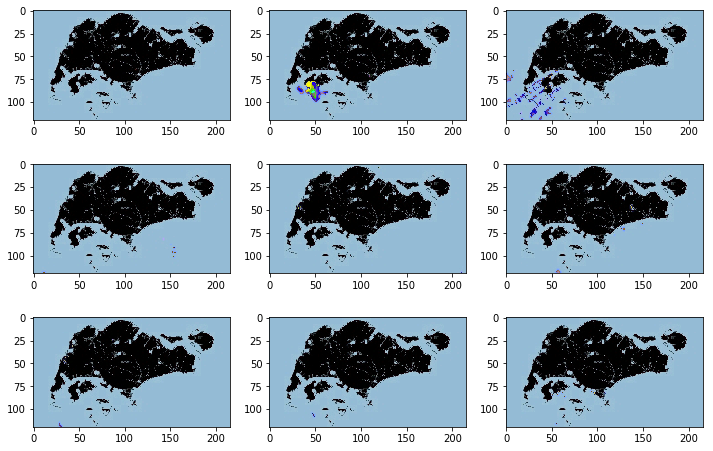

In [6]:
images_loaded = []

for image_path in tqdm_notebook(IMG_PATHS):
    image = cv2.imread(image_path)
    # scale image to range -1 to +1
    image = image/127.5 - 1.0
    images_loaded.append(image)
    
num_images = len(IMG_PATHS)

print("Showing 9 random images after scaling")

plt.figure(1, figsize=(12,8))

for i in range(9):
    n = random.randint(0, num_images-1)
    plt.subplot(3,3,i+1)
    # only use absolute to show image, when input, data is -1 to +1
    image = np.absolute(images_loaded[n])
    plt.imshow(image)
    
plt.show()

## Build model

In [7]:
# how many images for input and output sequence
# each image represents a 5 min interval

SEQUENCE_LENGTH = 6
IMAGE_WIDTH = 216
IMAGE_HEIGHT = 120
IMAGE_CHANNELS = 3

BATCH_SIZE = 16

Encoder portion

In [8]:
encoder_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS,), name='encoder_input')

x = TimeDistributed(Conv2D(512, kernel_size=3, activation='relu', padding='same'))(encoder_input)
x = TimeDistributed(Conv2D(256, kernel_size=3, activation='relu', padding='same'))(x)
x = TimeDistributed(Conv2D(256, kernel_size=3, activation='relu', padding='same'))(x)
encoder_output = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
print("encoder_output", encoder_output.shape)

encoder_output (?, 6, 60, 108, 256)


Decoder portion

In [9]:
y = TimeDistributed(Conv2DTranspose(256, kernel_size=3, activation='relu', padding='same'))(encoder_output)
y = TimeDistributed(UpSampling2D(2))(y)
y = TimeDistributed(Conv2DTranspose(256, kernel_size=3, activation='relu', padding='same'))(y)
y = TimeDistributed(Conv2DTranspose(256, kernel_size=3, activation='relu', padding='same'))(y)
decoder_output = TimeDistributed(Conv2DTranspose(3, kernel_size=3, activation='tanh', padding='same'))(y)

print("decoder_output", decoder_output.shape)

decoder_output (?, 6, 120, 216, 3)


Compile Model

In [10]:
model = Model(inputs=encoder_input, outputs=decoder_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 6, 120, 216, 3)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 120, 216, 512)  14336     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 120, 216, 256)  1179904   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 120, 216, 256)  590080    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 6, 60, 108, 256)   0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 60, 108, 256)   590080    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 6, 120, 216, 256)  0         
__________

## Training model

In [11]:
opt = keras.optimizers.Adadelta(lr=0.1)

model.compile(loss='mse',
              optimizer=opt,
              metrics=['mean_squared_error'])

callbacks_list = []

In [12]:
num_images = len(images_loaded)
split_index = int(num_images*0.8)
train_images = images_loaded[:split_index]
val_images = images_loaded[:split_index]

train_generator = data_generator(BATCH_SIZE, SEQUENCE_LENGTH, train_images)
validation_generator = data_generator(BATCH_SIZE, SEQUENCE_LENGTH, val_images)

steps_train = int(len(train_images)/BATCH_SIZE)
steps_val = int(len(val_images)/BATCH_SIZE)

In [13]:
# multi-gpu model
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model

parallel_model = multi_gpu_model(model, gpus=2)

parallel_model.compile(loss='mse',
                       optimizer=opt,
                       metrics=['mean_squared_error'])

In [14]:
print("Training Progress:")
model_log = parallel_model.fit_generator(train_generator, validation_data=validation_generator,
                                epochs=20, steps_per_epoch=steps_train, validation_steps=steps_val,
                                callbacks=callbacks_list)

Training Progress:
Epoch 1/20
  8/140 [>.............................] - ETA: 5:48 - loss: 0.1778 - mean_squared_error: 0.1778

KeyboardInterrupt: 